# Writing Context in LangGraph

*Writing context means saving it outside the context window to help an agent perform a task.*

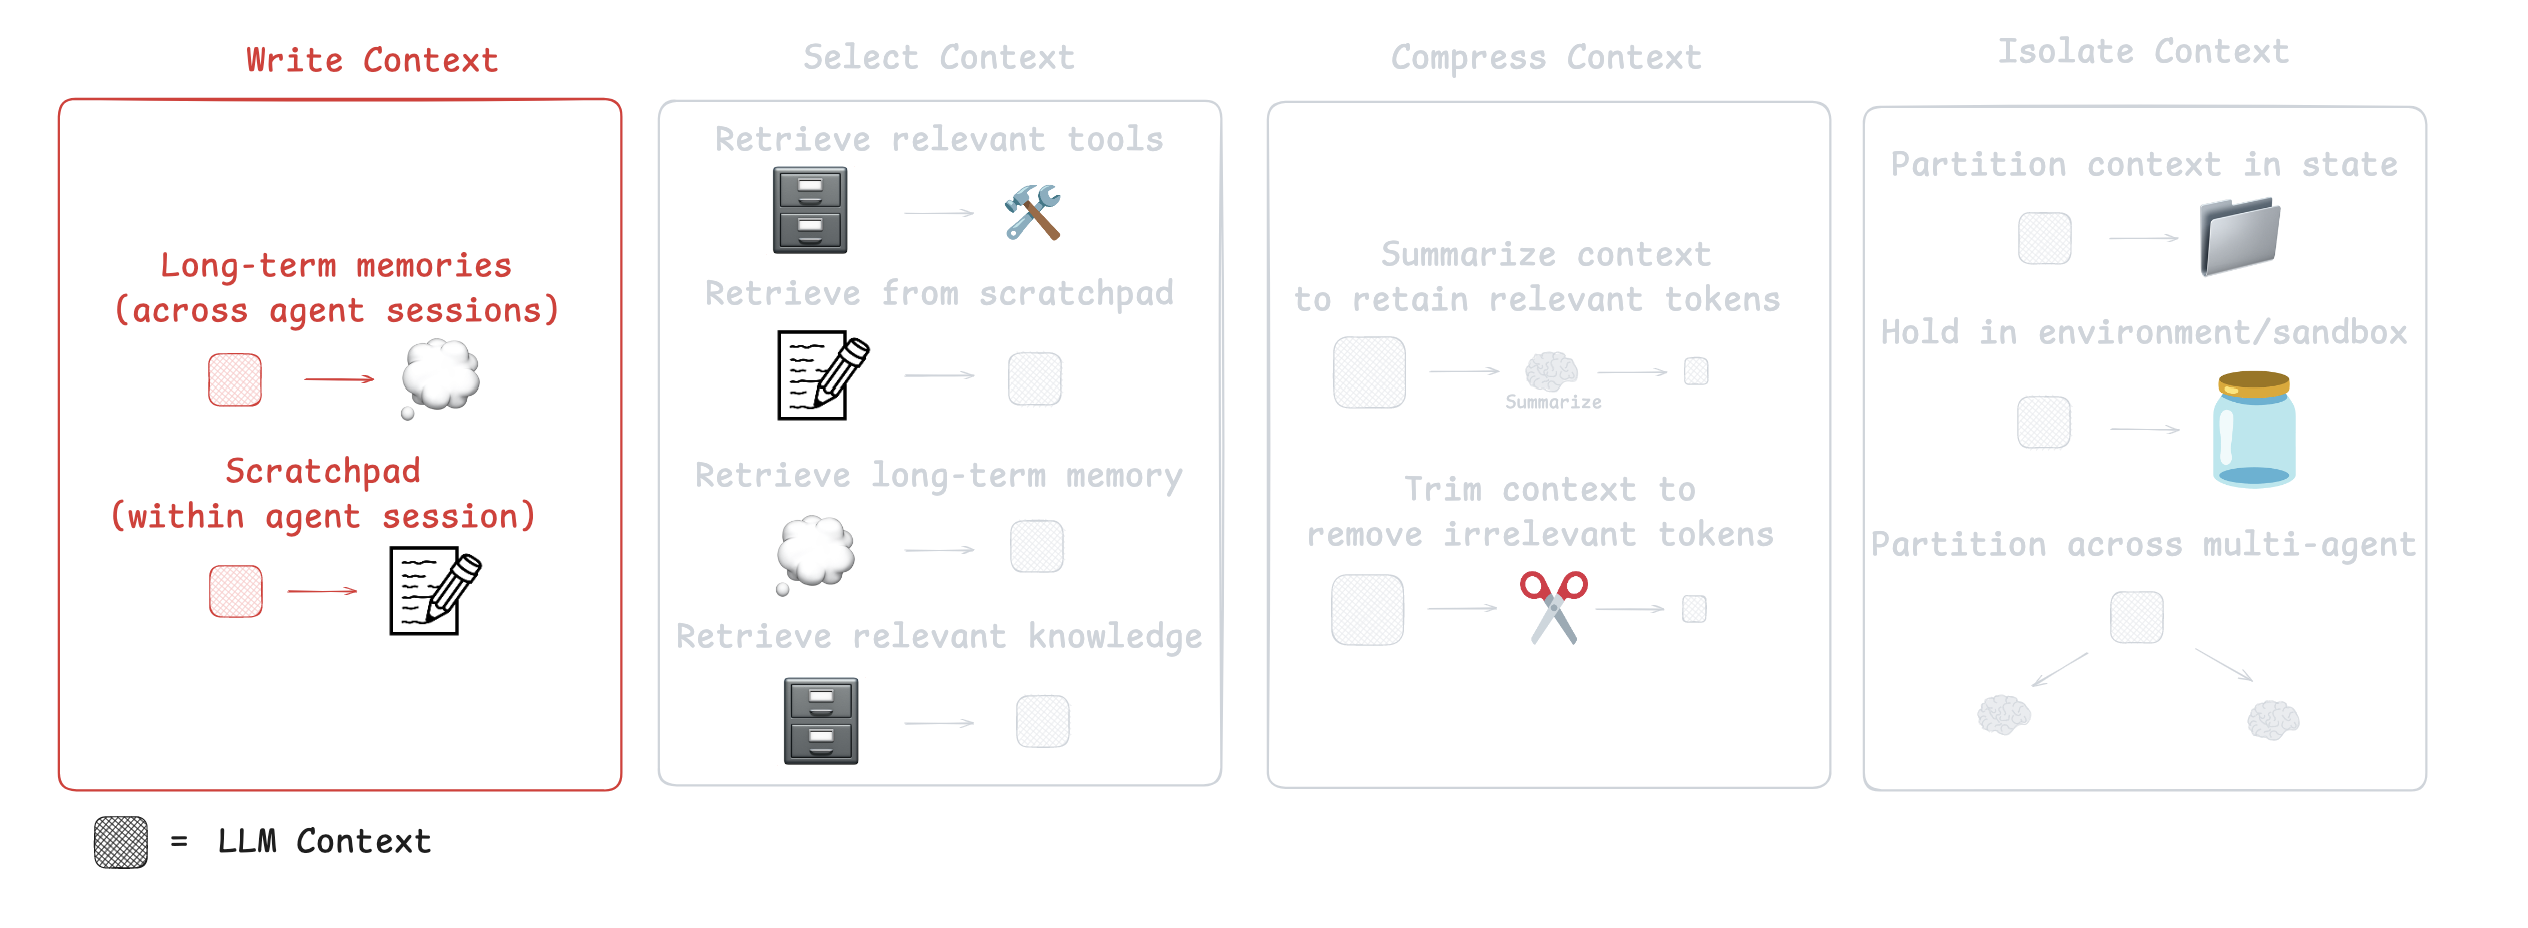

## Scratchpad

When humans solve tasks, we take notes and remember things for future, related tasks. Agents are also gaining these capabilities! Note-taking via a "[scratchpad](https://www.anthropic.com/engineering/claude-think-tool)" is one approach to persist information while an agent is performing a task. The central idea is to save information outside of the context window so that it's available to the agent on-demand. [Anthropic's multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) illustrates a clear example of this:

> The LeadResearcher begins by thinking through the approach and saving its plan to Memory to persist the context, since if the context window exceeds 200,000 tokens it will be truncated and it is important to retain the plan.

It's worth noting that this scratchpad can be implemented in a few different ways. It could be a [tool call](https://www.anthropic.com/engineering/claude-think-tool) that [writes to a file](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem). It could also just be a field in a runtime [state object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that persists during the session. In either case, the intuition is clear: scratchpads let agents save useful information during a session to help them accomplish tasks.

### Scratchpad writing in LangGraph

LangGraph was designed with first-class support of both thread-scoped ([short-term](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory)) and [long-term memory](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory). Short-term memory uses [checkpointing](https://langchain-ai.github.io/langgraph/concepts/persistence/) to persist [agent state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) across all steps of an agent session. This is extremely useful as s "scratchpad", allowing you to write information to state during agent execution and fetch it later as needed.

The state object in LangGraph serves as the central data structure that gets passed between nodes in your graph. You can decide the schema for this state object, but it's common to use a Python dictionary. The state acts as a shared scratchpad; each node can read from and write to specific fields. Let's create `TypedDict` a state object.

In [1]:
from typing import TypedDict

from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()


# Define a graph state with two fields
class State(TypedDict):
    """State schema for the joke generator workflow.
    
    Attributes:
        topic: The topic for joke generation
        joke: The generated joke content
    """
    topic: str
    joke: str

Once we've defined a state object, how do write context to it?

A [StateGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is LangGraph's primary abstraction for building stateful [agents or workflows](https://langchain-ai.github.io/langgraph/concepts/workflows/). Think of it as a directed graph where each node represents a function that can read from and modify the shared state, and edges define the flow of execution between nodes. 

Nodes are the individual processing steps in your workflow - they receive the current state as input and return updates to be merged back into the state. Edges connect these nodes together, creating a path for execution that can be linear, conditional, or even cyclical depending on your needs.

Let's first create a [chat model](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html) selecting from the list of [Anthropic models](https://docs.anthropic.com/en/docs/about-claude/models/overview) and then use it with a LangGraph workflow.

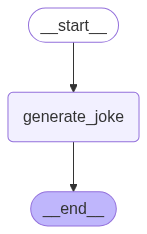

In [ ]:
import getpass
import os

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph


def _set_env(var: str) -> None:
    """Set environment variable if not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set up environment and initialize model
_set_env("OPENAI_API_KEY")
# I use openrouter to access openai models
# https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html
llm = init_chat_model("openai:openai/gpt-5", temperature=0, base_url="https://openrouter.ai/api/v1")


def generate_joke(state: State) -> dict[str, str]:
    """Generate a joke about the specified topic.
    
    This node reads the topic from state and generates a joke,
    then writes the joke back to state.
    
    Args:
        state: Current state containing the topic
        
    Returns:
        Dictionary with the generated joke
    """
    # Read the topic key from state, and pass it in the LLM prompt
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    
    # Write context (our joke) to a field in state
    return {"joke": msg.content}


# Initialize StateGraph with our state schema
workflow = StateGraph(State)

# Add our joke generation node to the workflow
workflow.add_node("generate_joke", generate_joke)

# Connect the node to workflow start and end
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile the workflow into an executable graph
chain = workflow.compile()

# Display the workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

In [4]:
# Execute the workflow with a specific topic
joke_generator_state = chain.invoke({"topic": "cats"})

# Display the resulting state with rich formatting
console.print("\n[bold blue]Joke Generator State:[/bold blue]")
pprint(joke_generator_state)

Joke Generator State:

{'topic': 'cats', 'joke': 'I told my cat I needed space—so he sat on the spacebar.'}

This simple example shows how we can write context to state. In the next notebook (`2_select_context.ipynb`), we'll use this written context in downstream nodes.

#### Learn More
 
* [Checkpointing](https://langchain-ai.github.io/langgraph/concepts/persistence/): Checkpointing in LangGraph creates snapshots of your graph's state after each node execution, enabling long-running tasks. These checkpoints allow you to pause execution, resume from any point, and even rewind to previous states. This is particularly valuable for complex workflows that might take hours or days to complete, as it provides fault tolerance and the ability to recover from failures without losing progress.

* [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/): Checkpointing enables human-in-the-loop workflows by allowing execution to be paused at any point and resumed later. This means you can interrupt a running graph, wait for human input or approval, and then continue processing from exactly where you left off. The checkpointed state ensures that all context and progress is preserved across these interruptions, making it possible to build workflows that seamlessly blend automated processing with human oversight and decision-making.

## Memory 

Scratchpads helps agents solve a task within a given session, but sometimes agents benefit from remembering things across *many* sessions! [Reflexion](https://arxiv.org/abs/2303.11366) introduced the idea of reflection following each agent turn and re-using these self-generated hints. [Generative Agents](https://ar5iv.labs.arxiv.org/html/2304.03442) created memories synthesized periodically from collections of past agent feedback.

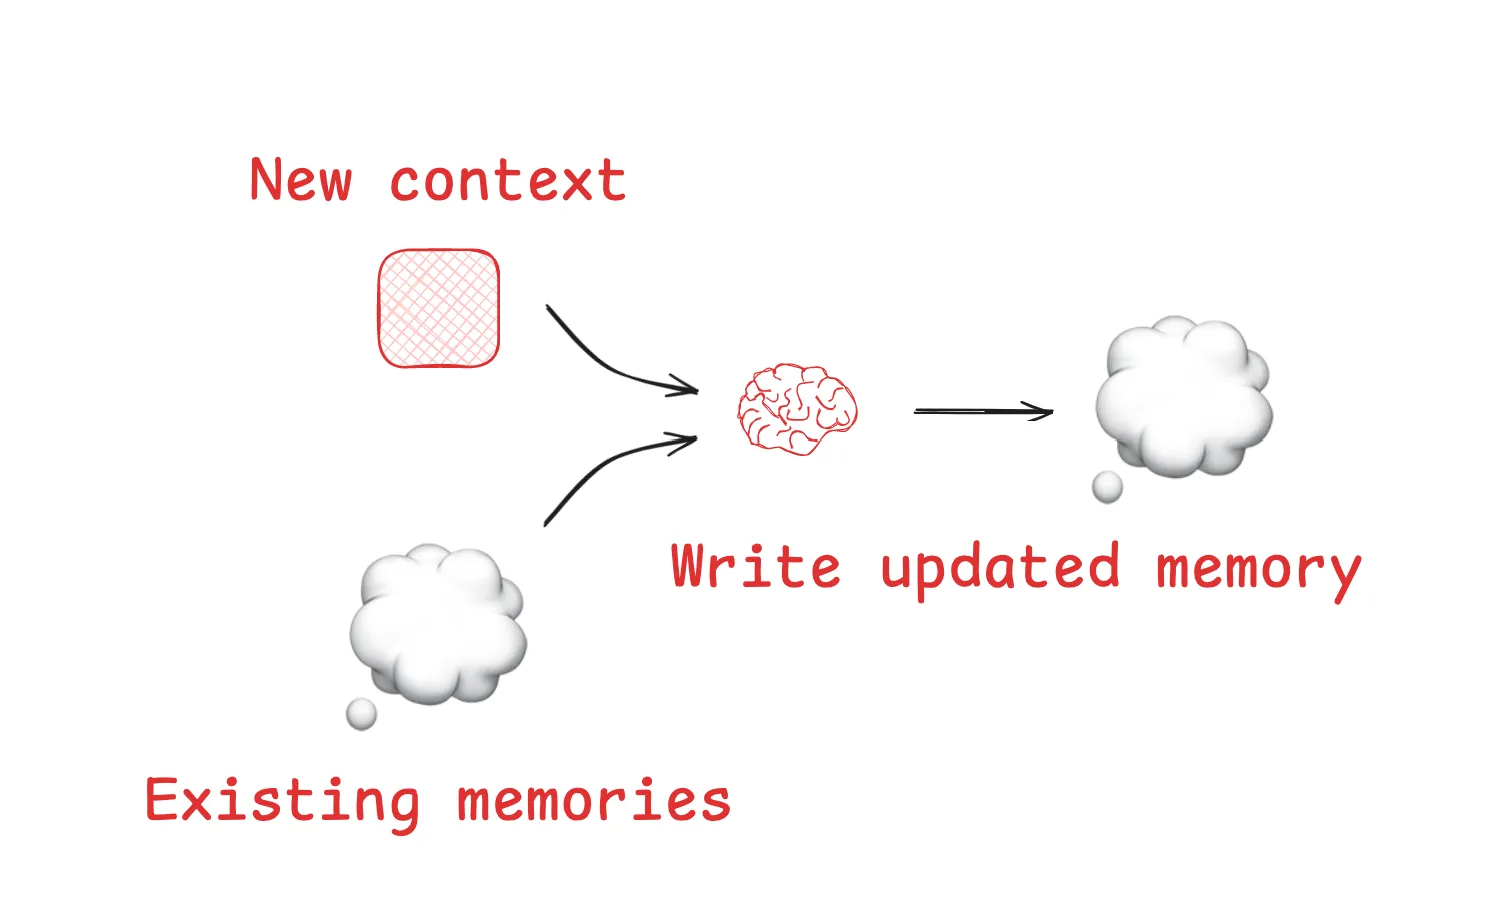

These concepts made their way into popular products like [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq), [Cursor](https://forum.cursor.com/t/0-51-memories-feature/98509), and [Windsurf](https://docs.windsurf.com/windsurf/cascade/memories), which all have mechanisms to auto-generate long-term memories based on user-agent interactions.

### Memory writing in LangGraph

Checkpointing saves the state of your graph at each step. These are saved to a [thread](https://langchain-ai.github.io/langgraph/concepts/persistence/). Each thread is referenced by a unique identifier and typically represents a single interaction with an agent. It it analogous to a single "chat thread" with ChatGPT, for example.

LangGraph’s long-term memory allows you to persist specific context *across threads* with your agent. It is flexible, allowing you to save [individual files](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) (e.g., a user profile) or [collections](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of memories. 

LangGraph’s long-term memory uses the [BaseStore](https://langchain-ai.github.io/langgraph/reference/store/) interface, which is a key-value store. It can be use in memory, as we show below in this notebook. It also can be used with [LangGraph Platform deployments](https://langchain-ai.github.io/langgraph/concepts/persistence/#langgraph-platform).

Let's create an `InMemoryStore` for use across a few different sessions in our notebook.

In [5]:
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store for long-term memory
store = InMemoryStore()

# Define namespace as a tuple (user_id, application_context)
namespace = ("rlm", "joke_generator")

# Write context as a key-value pair to the namespace
store.put(
    namespace,                             # namespace for organizing data
    "last_joke",                          # key for this specific piece of data
    {"joke": joke_generator_state["joke"]} # value to store
)

We'll talk more about selecting context from the namespace in the next notebook.

For now, we can just use the [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to view items within a namespace and see that we wrote to it.

In [6]:
# Search the namespace to view all stored items
stored_items = list(store.search(namespace))

# Display the stored items with rich formatting
console.print("\n[bold green]Stored Items in Memory:[/bold green]")
pprint(stored_items)

Stored Items in Memory:

[
│   Item(namespace=['rlm', 'joke_generator'], key='last_joke', value={'joke': 'I told my cat I needed space—so he sat on the spacebar.'}, created_at='2025-09-14T14:19:23.368313+00:00', updated_at='2025-09-14T14:19:23.368317+00:00', score=None)
]

Now, let's just embed what we did inside a LangGraph workflow.

We compile our workflow with two arguments: 

* `checkpointer`: Save graph state at each step to a thread 
* `store`: Persist context across threads

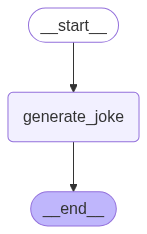

In [7]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# Initialize storage components
checkpointer = InMemorySaver()  # For thread-level state persistence
memory_store = InMemoryStore()  # For cross-thread memory storage


def generate_joke(state: State, store: BaseStore) -> dict[str, str]:
    """Generate a joke with memory awareness.
    
    This enhanced version checks for existing jokes in memory
    before generating new ones.
    
    Args:
        state: Current state containing the topic
        store: Memory store for persistent context
        
    Returns:
        Dictionary with the generated joke
    """
    # Check if there's an existing joke in memory
    existing_jokes = list(store.search(namespace))
    if existing_jokes:
        existing_joke = existing_jokes[0].value
        print(f"Existing joke: {existing_joke}")
    else:
        print("Existing joke: No existing joke")

    # Generate a new joke based on the topic
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    
    # Store the new joke in long-term memory
    store.put(namespace, "last_joke", {"joke": msg.content})

    # Return the joke to be added to state
    return {"joke": msg.content}


# Build the workflow with memory capabilities
workflow = StateGraph(State)

# Add the memory-aware joke generation node
workflow.add_node("generate_joke", generate_joke)

# Connect the workflow components
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile with both checkpointing and memory store
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

# Display the enhanced workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
# Execute the workflow with thread-based configuration
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

# Display the workflow result with rich formatting
console.print("\n[bold cyan]Workflow Result (Thread 1):[/bold cyan]")
pprint(joke_generator_state)

Existing joke: No existing joke


Workflow Result (Thread 1):

{'topic': 'cats', 'joke': 'Why did the cat sit on the computer? It wanted to keep an eye on the mouse.'}

Because we compiled with a checkpointer, we can see the [latest state](https://langchain-ai.github.io/langgraph/concepts/persistence/#get-state) of the graph!

In [9]:
# Retrieve the latest state snapshot from the checkpointer
latest_state = chain.get_state(config)

# Display the complete state snapshot with rich formatting
console.print("\n[bold magenta]Latest Graph State:[/bold magenta]")
pprint(latest_state)

Latest Graph State:

StateSnapshot(
│   values={
│   │   'topic': 'cats',
│   │   'joke': 'Why did the cat sit on the computer? It wanted to keep an eye on the mouse.'
│   },
│   next=(),
│   config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f091760-2e53-65de-8001-5b747817245c'
│   │   }
│   },
│   metadata={'source': 'loop', 'step': 1, 'parents': {}},
│   created_at='2025-09-14T14:20:48.922970+00:00',
│   parent_config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f09175f-de5f-6fe6-8000-d51f85ee88fb'
│   │   }
│   },
│   tasks=(),
│   interrupts=()
)

In [10]:
# Execute the workflow with a different thread ID
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

# Display the result showing memory persistence across threads
console.print("\n[bold yellow]Workflow Result (Thread 2):[/bold yellow]")
pprint(joke_generator_state)

Existing joke: {'joke': 'Why did the cat sit on the computer? It wanted to keep an eye on the mouse.'}


Workflow Result (Thread 2):

{
│   'topic': 'cats',
│   'joke': 'I asked my cat to help with chores—he said he’ll get to it in one of his next nine lives.'
}

We can see that the joke from the first thread was saved to memory.

#### Learn More

* [LangMem](https://langchain-ai.github.io/langmem/) provides a set of useful abstractions to aid with writing memories.
* [Ambient Agents Course](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/memory.ipynb) provides a great overview of memory with a LangGraph agent.